Plot the loaded data samples to verify the correctness of data loading and preprocessing.

Loading videos from ['data_gen/davis/train']:
Loading videos from ['data_gen/davis/val']:
Loading videos from ['data_gen/davis/test']:
Batch 1 data shape: torch.Size([3, 1, 16, 128, 128])
Plotting the first 10 frames of video 1


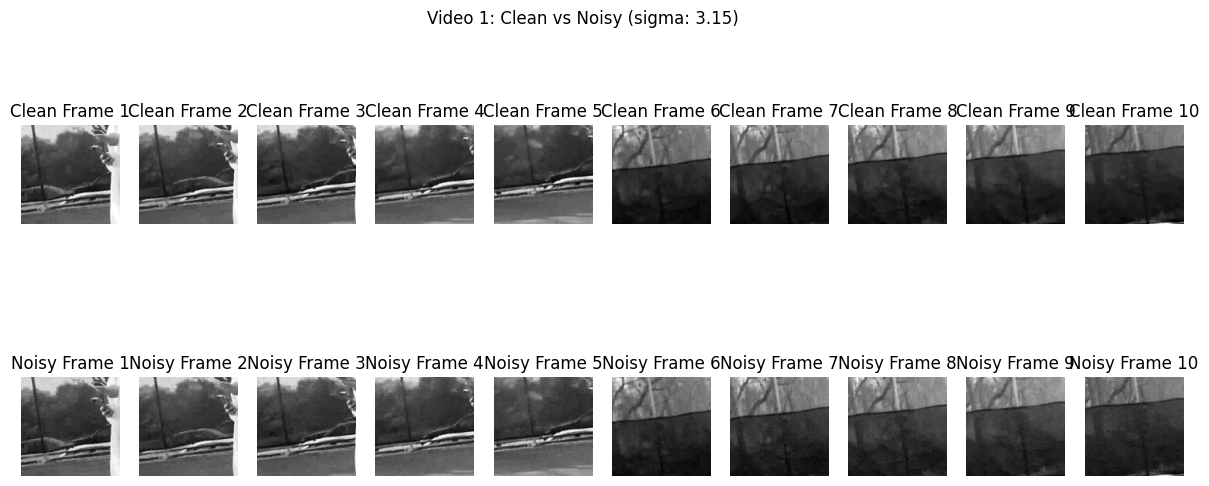

In [11]:
import os
import matplotlib.pyplot as plt
import torch
from data3d import get_fit_loaders

def awgn3d(input, noise_std):
    """ Additive White Gaussian Noise
    y: clean input image
    noise_std: (tuple) noise_std of batch size N is uniformly sampled 
               between noise_std[0] and noise_std[1]. Expected to be in interval
               [0,255]
    """
    if not isinstance(noise_std, (list, tuple)):
        sigma = noise_std
    else:  # uniform sampling of sigma
        sigma = noise_std[0] + \
               (noise_std[1] - noise_std[0]) * torch.rand(len(input), 1, 1, 1, 1, device=input.device)
    return input + torch.randn_like(input) * (sigma / 255), sigma

def plot_sample_frames_with_noise(dataloader, num_videos=1, num_frames=5, noise_std=(0, 25)):
    """
    Plot the first few frames of sample videos from the data loader and compare
    clean vs noisy frames.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object.
        num_videos (int): Number of videos to plot.
        num_frames (int): Number of frames to plot for each video.
        noise_std (tuple): Standard deviation range for Gaussian noise.
    """
    # Get a batch of data
    for batch_idx, batch_data in enumerate(dataloader):
        # Shape of batch_data: (batch_size, C, D, H, W)
        print(f"Batch {batch_idx + 1} data shape: {batch_data.shape}")
        
        batch_size, C, D, H, W = batch_data.shape
        
        # Apply noise to the batch
        noisy_batch, sigma = awgn3d(batch_data, noise_std)
        
        for video_idx in range(min(num_videos, batch_size)):
            video_clean = batch_data[video_idx]  # Shape: (C, D, H, W)
            video_noisy = noisy_batch[video_idx]  # Shape: (C, D, H, W)
            print(f"Plotting the first {num_frames} frames of video {video_idx + 1}")
            
            # Create a figure window
            fig, axes = plt.subplots(2, num_frames, figsize=(15, 6))
            fig.suptitle(f'Video {video_idx + 1}: Clean vs Noisy (sigma: {sigma[video_idx].item():.2f})')
            
            for frame_idx in range(num_frames):
                if frame_idx >= D:
                    break  # Prevent insufficient frames
                
                # Get single frame data (clean and noisy)
                frame_clean = video_clean[:, frame_idx, :, :]  # Shape: (C, H, W)
                frame_noisy = video_noisy[:, frame_idx, :, :]  # Shape: (C, H, W)
                
                # Convert to NumPy array
                frame_clean_np = frame_clean.numpy()
                frame_noisy_np = frame_noisy.numpy()
                
                # If grayscale, remove the channel dimension
                if C == 1:
                    frame_clean_np = frame_clean_np.squeeze(0)
                    frame_noisy_np = frame_noisy_np.squeeze(0)
                    axes[0, frame_idx].imshow(frame_clean_np, cmap='gray')
                    axes[1, frame_idx].imshow(frame_noisy_np, cmap='gray')
                else:
                    # For color images, convert to (H, W, C)
                    frame_clean_np = frame_clean_np.transpose(1, 2, 0)
                    frame_noisy_np = frame_noisy_np.transpose(1, 2, 0)
                    axes[0, frame_idx].imshow(frame_clean_np)
                    axes[1, frame_idx].imshow(frame_noisy_np)
                
                axes[0, frame_idx].axis('off')
                axes[0, frame_idx].set_title(f'Clean Frame {frame_idx + 1}')
                
                axes[1, frame_idx].axis('off')
                axes[1, frame_idx].set_title(f'Noisy Frame {frame_idx + 1}')
            
            plt.show()
            
            # Only plot the specified number of videos
            if video_idx + 1 >= num_videos:
                return

def main():
    # Define path lists (adjust according to your actual paths)
    trn_path_list = ['data_gen/davis/train']
    val_path_list = ['data_gen/davis/val']
    tst_path_list = ['data_gen/davis/test']

    # Get data loaders
    dataloaders = get_fit_loaders(
        trn_path_list=trn_path_list,
        val_path_list=val_path_list,
        tst_path_list=tst_path_list,
        crop_size=128,
        batch_size=[3, 1, 1],  # Use a smaller batch size for testing
        load_color=False,       # Set to False to load grayscale images
        depth=16
    )

    # Select one data loader, e.g., training set
    train_loader = dataloaders['train']

    # Plot sample frames with noise
    plot_sample_frames_with_noise(train_loader, num_videos=1, num_frames=10, noise_std=(0, 25))

if __name__ == "__main__":
    main()


Test training pipline

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from data3d import get_fit_loaders
from model.net import CDLNetVideo

def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, batch_data in enumerate(dataloader):
            noisy_batch, sigma = awgn3d(batch_data, noise_std=25)
            noisy_batch = noisy_batch.to('cuda')
            batch_data = batch_data.to('cuda')
            
            optimizer.zero_grad()
            output, z = model(noisy_batch, sigma=25)
            loss = criterion(output, batch_data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        
        scheduler.step()

dataloaders = get_fit_loaders(
    trn_path_list=['data_gen/data16/train'],
    val_path_list=['data_gen/data16/val'],
    tst_path_list=['data_gen/data16/test'],
    crop_size=128,
    batch_size=[1, 1, 1],
    load_color=False,
    depth=16
)

train_loader = dataloaders['train']

model = CDLNetVideo(
            K=30,
            M=169,
            P=7,
            s=2,
            C=1,           
            t0=0,
            adaptive=True,
            init=True
        ).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.95)

Loading videos from ['data_gen/data16/train']:
Loading videos from ['data_gen/data16/val']:
Loading videos from ['data_gen/data16/test']:
Running power-method on initial dictionary...
Done. L=1.375e+04.


In [3]:
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=2)

Epoch [1/2], Step [1/2000], Loss: 0.0096
Epoch [1/2], Step [11/2000], Loss: 0.0069
Epoch [1/2], Step [21/2000], Loss: 0.0053
Epoch [1/2], Step [31/2000], Loss: 0.0039
Epoch [1/2], Step [41/2000], Loss: 0.0024
Epoch [1/2], Step [51/2000], Loss: 0.0016
Epoch [1/2], Step [61/2000], Loss: 0.0012
Epoch [1/2], Step [71/2000], Loss: 0.0008
Epoch [1/2], Step [81/2000], Loss: 0.0008
Epoch [1/2], Step [91/2000], Loss: 0.0005
Epoch [1/2], Step [101/2000], Loss: 0.0005
Epoch [1/2], Step [111/2000], Loss: 0.0003
Epoch [1/2], Step [121/2000], Loss: 0.0003
Epoch [1/2], Step [131/2000], Loss: 0.0002
Epoch [1/2], Step [141/2000], Loss: 0.0003
Epoch [1/2], Step [151/2000], Loss: 0.0002
Epoch [1/2], Step [161/2000], Loss: 0.0002
Epoch [1/2], Step [171/2000], Loss: 0.0002
Epoch [1/2], Step [181/2000], Loss: 0.0002
Epoch [1/2], Step [191/2000], Loss: 0.0002
Epoch [1/2], Step [201/2000], Loss: 0.0001
Epoch [1/2], Step [211/2000], Loss: 0.0001
Epoch [1/2], Step [221/2000], Loss: 0.0001
Epoch [1/2], Step [231

Batch 1 data shape: torch.Size([1, 1, 16, 128, 128])
Plotting the first 5 frames of video 1


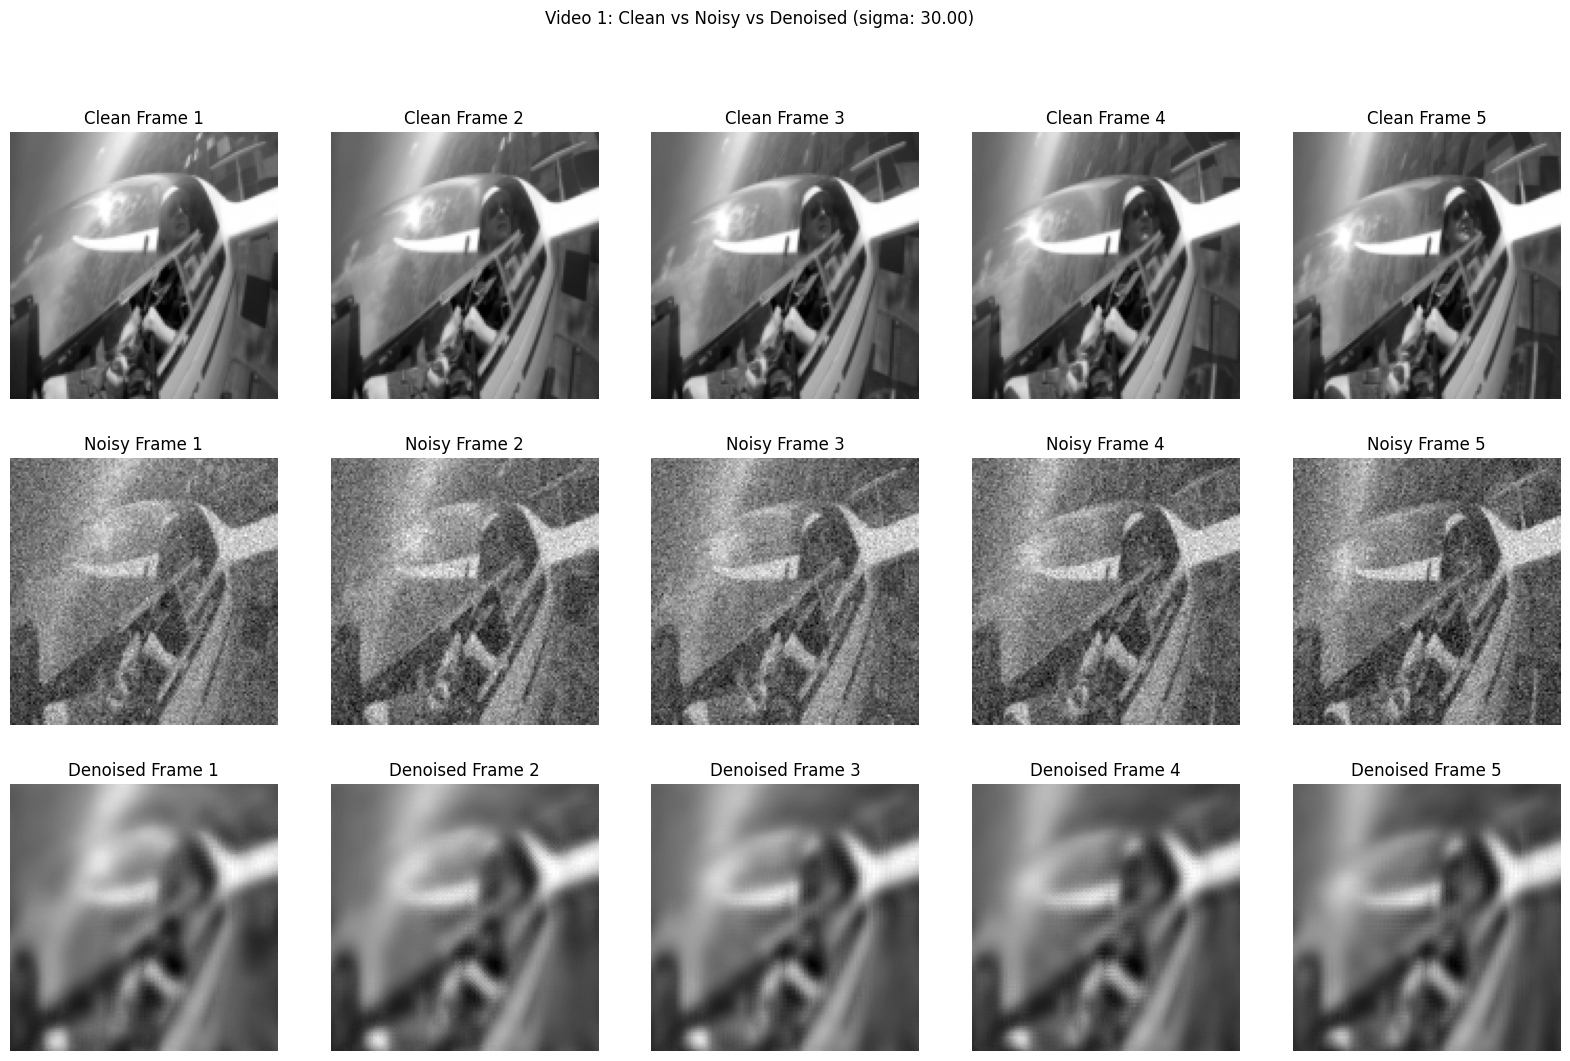

In [11]:
plot_sample_frames_with_denoising(model, dataloaders['test'], num_videos=1, num_frames=5, noise_std=30)

In [8]:
def plot_sample_frames_with_denoising(model, dataloader, num_videos=1, num_frames=5, noise_std=(0, 25)):
    """
    Plot the first few frames of sample videos from the data loader and compare
    clean vs noisy vs denoised frames using the model.
    
    Args:
        model (torch.nn.Module): The denoising model to use for inference.
        dataloader (DataLoader): PyTorch DataLoader object.
        num_videos (int): Number of videos to plot.
        num_frames (int): Number of frames to plot for each video.
        noise_std (tuple): Standard deviation range for Gaussian noise.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(dataloader):
            print(f"Batch {batch_idx + 1} data shape: {batch_data.shape}")
            batch_size, C, D, H, W = batch_data.shape
            
            # Apply noise to the batch
            noisy_batch, sigma = awgn3d(batch_data, noise_std)
            noisy_batch = noisy_batch.to('cuda')  # Move to GPU
            batch_data = batch_data.to('cuda')  # Move to GPU
            
            # Perform inference to get denoised output
            denoised_batch, _ = model(noisy_batch, sigma=25)
            
            for video_idx in range(min(num_videos, batch_size)):
                video_clean = batch_data[video_idx].cpu()  # Move back to CPU for plotting
                video_noisy = noisy_batch[video_idx].cpu()
                video_denoised = denoised_batch[video_idx].cpu()
                print(f"Plotting the first {num_frames} frames of video {video_idx + 1}")
                
                # Create a figure window
                fig, axes = plt.subplots(3, num_frames, figsize=(20, 12))
                fig.suptitle(f'Video {video_idx + 1}: Clean vs Noisy vs Denoised (sigma: {sigma:.2f})')
                
                for frame_idx in range(num_frames):
                    if frame_idx >= D:
                        break  # Prevent insufficient frames
                    
                    # Get single frame data (clean, noisy, denoised)
                    frame_clean = video_clean[:, frame_idx, :, :]  # Shape: (C, H, W)
                    frame_noisy = video_noisy[:, frame_idx, :, :]  # Shape: (C, H, W)
                    frame_denoised = video_denoised[:, frame_idx, :, :]  # Shape: (C, H, W)
                    
                    # Convert to NumPy array
                    frame_clean_np = frame_clean.numpy()
                    frame_noisy_np = frame_noisy.numpy()
                    frame_denoised_np = frame_denoised.numpy()
                    
                    # If grayscale, remove the channel dimension
                    if C == 1:
                        frame_clean_np = frame_clean_np.squeeze(0)
                        frame_noisy_np = frame_noisy_np.squeeze(0)
                        frame_denoised_np = frame_denoised_np.squeeze(0)
                        axes[0, frame_idx].imshow(frame_clean_np, cmap='gray')
                        axes[1, frame_idx].imshow(frame_noisy_np, cmap='gray')
                        axes[2, frame_idx].imshow(frame_denoised_np, cmap='gray')
                    else:
                        # For color images, convert to (H, W, C)
                        frame_clean_np = frame_clean_np.transpose(1, 2, 0)
                        frame_noisy_np = frame_noisy_np.transpose(1, 2, 0)
                        frame_denoised_np = frame_denoised_np.transpose(1, 2, 0)
                        axes[0, frame_idx].imshow(frame_clean_np)
                        axes[1, frame_idx].imshow(frame_noisy_np)
                        axes[2, frame_idx].imshow(frame_denoised_np)
                    
                    axes[0, frame_idx].axis('off')
                    axes[0, frame_idx].set_title(f'Clean Frame {frame_idx + 1}')
                    
                    axes[1, frame_idx].axis('off')
                    axes[1, frame_idx].set_title(f'Noisy Frame {frame_idx + 1}')
                    
                    axes[2, frame_idx].axis('off')
                    axes[2, frame_idx].set_title(f'Denoised Frame {frame_idx + 1}')
                
                plt.show()
                
                # Only plot the specified number of videos
                if video_idx + 1 >= num_videos:
                    return


In [2]:
import os
from PIL import Image

# 定义文件夹路径
input_folder = 'gt'
output_folder = 'gt_gray'

# 创建输出文件夹，如果不存在
os.makedirs(output_folder, exist_ok=True)

# 遍历文件夹中的所有文件
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # 可以根据需要添加其他格式
        # 打开图像
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # 转换为灰度图
        gray_img = img.convert('L')

        # 保存灰度图像
        gray_img_path = os.path.join(output_folder, filename)
        gray_img.save(gray_img_path)

print("所有图像已转换为灰度图并保存到", output_folder)


所有图像已转换为灰度图并保存到 gt_gray
